# Marketing A/B Testing

<b>Notebook created by:</b> Matilda Eriksson
<br>
<b>Date:</b> 2021-02-02
<br>
<b>Data source:</b> https://github.com/pthiagu2/DataMining/blob/master/WA_Fn-UseC_-Marketing-Campaign-Eff-UseC_-FastF.csv
<br>
<b>Latest updated (by):</b>  2021-02-08 <i>(Matilda Eriksson)</i>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# EDA

In [4]:
campaign = pd.read_csv('marketing_campaign.csv')
len(campaign)

548

In [5]:
campaign.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [6]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [7]:
# Summary statistics for the numeric variable
campaign.SalesInThousands.describe()

count    548.000000
mean      53.466204
std       16.755216
min       17.340000
25%       42.545000
50%       50.200000
75%       60.477500
max       99.650000
Name: SalesInThousands, dtype: float64

In [8]:
campaign.duplicated().sum()

0

In [9]:
campaign.isna().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [10]:
#sns.pairplot(campaign, height=3);

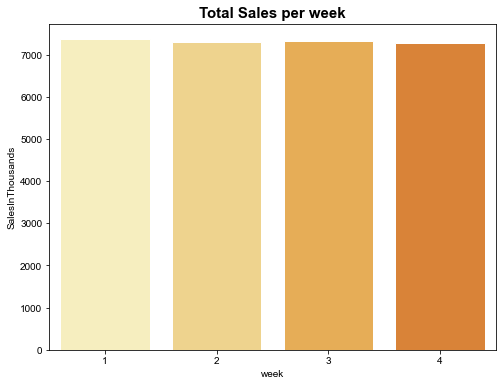

In [11]:
sales_per_week = campaign.groupby('week', as_index=False).agg({'SalesInThousands': 'sum'})
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.set_palette("YlOrBr")
ax = sns.barplot(x='week', y='SalesInThousands', data = sales_per_week)
ax.set_title('Total Sales per week', size=15, weight='bold')
plt.show();

<b> According to the bar chart above, there's no significant difference between the 4 weeks.
<br>
<br>
I'm not intrested in comparing the promotions week-by-week, so my plan is to group each LocationID's observations total sales amount for all weeks.
<br>
<br>
To make sure this will not cause any problems I first have to make sure that:
<br>
.. each LocationID is only running one unique Promotion
<br>
.. each LocationID have data for all four weeks. 
<br>
MarketSize, MarketID and AgeofStore should be the same for each row of the specific LocationID.
</b>

In [14]:
# Does any LocationID have more than one type of Promotion?
grouped_df = campaign.groupby("LocationID")
grouped_df = grouped_df.agg({"Promotion": "nunique"}).reset_index()
over_1 = (grouped_df['Promotion'] > 1)
grouped_df[over_1].sum()
# No

LocationID    0
Promotion     0
dtype: int64

In [15]:
# Does all Locations have four weeks? 
grouped_dr = campaign.groupby("LocationID")
grouped_dr = grouped_dr.agg({"week": "nunique"}).reset_index()
grouped_dr[grouped_dr['week'] < 4].sum()
# Yes

LocationID    0
week          0
dtype: int64

<b>I will create a new dataframe that contains one row per LocationID with total sales for all weeks.</b>

In [16]:
# Start by creating a df that contains the total sales for each LocationID
total_sales_per_location = campaign.groupby('LocationID', as_index=False).agg({'SalesInThousands': 'sum'})

# I then create another dataframe where I drop duplicate rows for LocationID, only keeping the first one 
# (which one I keep is not the most important here)
campaign_total = campaign.drop_duplicates(subset='LocationID', keep='first').reset_index(drop=True)

# I add the total sales to my new df
campaign_total['Total_Sales'] = total_sales_per_location['SalesInThousands']
# And drop the columns that are now irrelevant
campaign_total.drop(columns=['SalesInThousands', 'week'], inplace=True)

In [17]:
len(campaign_total)

137

<b> I will now do some more exploratory data analysis</b>

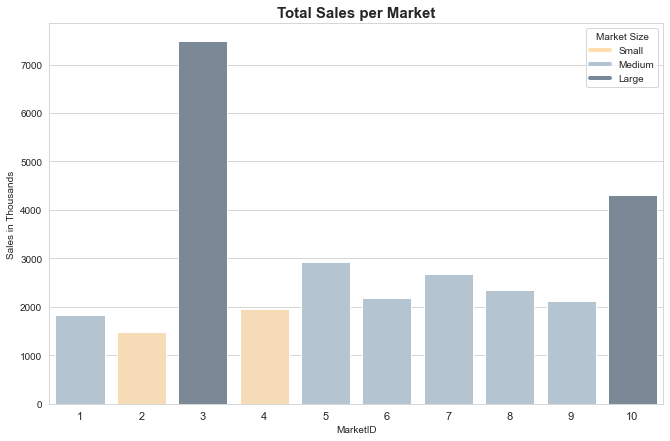

In [19]:
# Total Sales per MarketID
per_market = campaign_total.groupby('MarketID', as_index=False).Total_Sales.sum().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(11,7))
sns.set_style('whitegrid')
clrs = ['navajowhite' if (x == 2 or x == 4) else 'lightslategrey' if (x == 3 or x == 10) else '#b0c4d6' for x in per_market.MarketID]
fig = sns.barplot(x='MarketID', y='Total_Sales', data=per_market, palette=clrs)
ax.set_title('Total Sales per Market', size=15, weight='bold')
ax.set_ylabel('Sales in Thousands')

legend_elements = [Line2D([0], [0], color='navajowhite', lw=4, label='Small'),
                   Line2D([0], [0], color='#b0c4d6', lw=4, label='Medium'),
                   Line2D([0], [0], color='lightslategrey', lw=4, label='Large')]
ax.legend(title='Market Size', handles=legend_elements)

plt.xticks(ticks=np.arange(0,10), labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], size=11)
plt.show();

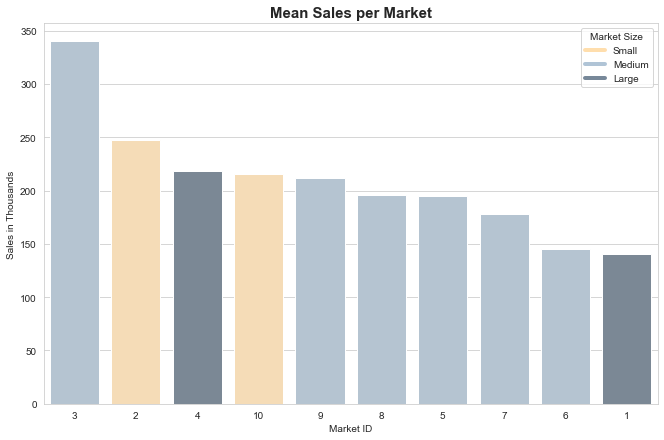

In [20]:
# Total Sales per MarketID
mean_per_market = campaign_total.groupby('MarketID', as_index=False).Total_Sales.mean().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(11,7))
sns.set_style('whitegrid')
clrs = ['navajowhite' if (x == 2 or x == 4) else 'lightslategrey' if (x == 3 or x == 10) else '#b0c4d6' for x in mean_per_market.MarketID]
fig = sns.barplot(x='MarketID', y='Total_Sales', data=mean_per_market, palette=clrs, order=mean_per_market.sort_values('Total_Sales', ascending=False).MarketID)
ax.set_title('Mean Sales per Market', size=15, weight='bold')
ax.set_ylabel('Sales in Thousands')
ax.set_xlabel('Market ID')

legend_elements = [Line2D([0], [0], color='navajowhite', lw=4, label='Small'),
                   Line2D([0], [0], color='#b0c4d6', lw=4, label='Medium'),
                   Line2D([0], [0], color='lightslategrey', lw=4, label='Large')]
ax.legend(title='Market Size', handles=legend_elements)
plt.show();

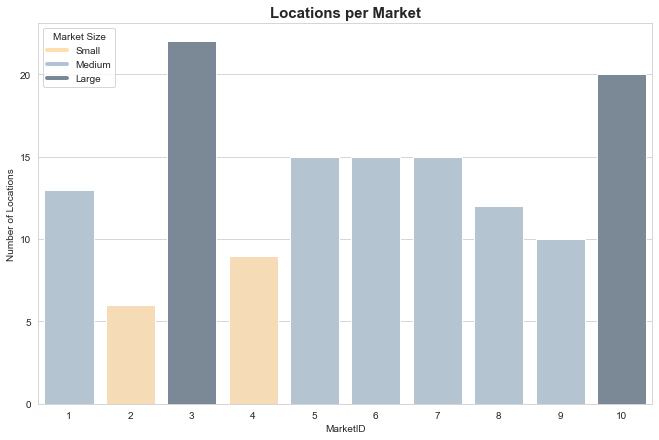

In [21]:
# Number of locations per market
locations_per_market = campaign_total.groupby('MarketID', as_index=False).LocationID.count()
fig, ax = plt.subplots(figsize=(11, 7))
sns.set_style('whitegrid')
clrs = ['navajowhite' if (x == 2 or x == 4) else 'lightslategrey' if (x == 3 or x == 10) else '#b0c4d6' for x in per_market.MarketID]
clrs = ['navajowhite' if (x == 2 or x == 4) else 'lightslategrey' if (x == 3 or x == 10) else '#b0c4d6' for x in locations_per_market.MarketID]
ax = sns.barplot(x='MarketID', y='LocationID', data=locations_per_market, ci=None, palette = clrs)
ax.set_ylabel('Number of Locations')
plt.title('Locations per Market', size=15, weight='bold')
legend_elements = [Line2D([0], [0], color='navajowhite', lw=4, label='Small'),
                   Line2D([0], [0], color='#b0c4d6', lw=4, label='Medium'),
                   Line2D([0], [0], color='lightslategrey', lw=4, label='Large')]
ax.legend(title='Market Size', handles=legend_elements)
plt.show();

<b>Market Size seems to be correlated to the number of locations within that Market</b>

In [22]:
median_sales = np.round(np.median(campaign_total['Total_Sales']))
mean_sales = np.round(np.mean(campaign_total['Total_Sales']))
std_sales = np.round(np.std(campaign_total['Total_Sales']))

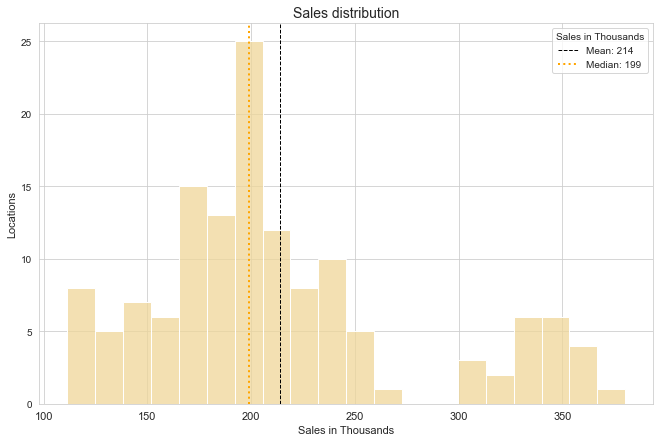

In [23]:
# Distribution of Sales Amount among Location's
fig, ax = plt.subplots(figsize=(11,7))
sns.set_style('whitegrid')
ax = sns.histplot(campaign_total['Total_Sales'], color='#efd699', bins=20)
ax.set_ylabel('Locations',size=11)
ax.set_xlabel('Sales in Thousands', size=11)
ax.set_title('Sales distribution', size=14)
plt.xticks(ticks=np.arange(100,400,50), labels=['100', '150', '200', '250', '300', '350'], size=11)
plt.axvline(mean_sales, color='k', linestyle='dashed', linewidth=1, label='Mean: {}'.format(mean_sales.astype(int)))
plt.axvline(median_sales, color='orange', linestyle='dotted', linewidth=2, label='Median: {}'.format(median_sales.astype(int)))
plt.legend(title='Sales in Thousands')
plt.show();

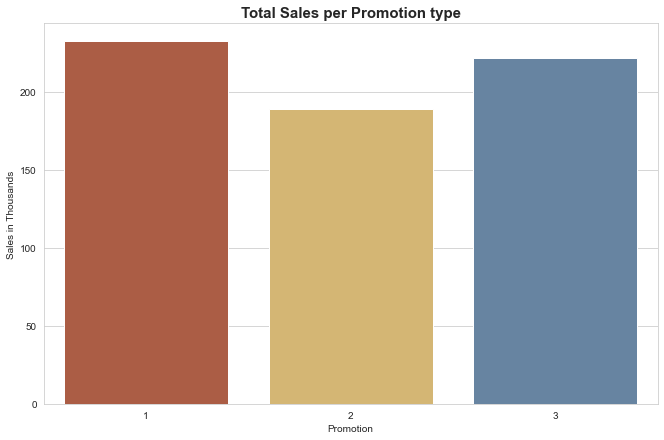

In [24]:
# Sales per promotion
per_campaign = campaign_total.groupby('Promotion', as_index=False).Total_Sales.mean()
fig, ax = plt.subplots(figsize=(11, 7))
sns.set_style('whitegrid')
sns.set_palette("YlOrBr")
clrs = ['#bc5434' if x == 1 else '#e4bc64' if x == 2 else '#5d84ab' for x in per_campaign.Promotion]
ax = sns.barplot(x='Promotion', y='Total_Sales', data=per_campaign, ci=None, palette=clrs)
ax.set_ylabel('Sales in Thousands')
ax.set_xlabel('Promotion')
plt.title('Total Sales per Promotion type', size=15, weight='bold')
#plt.savefig('temp123.png', transparent=True, bbox_inches='tight', dpi=200)
plt.show();

<b> Looking at the bar chart above, Promotion 2 seems to have performed best. I will investigate if this is the case later on</b>

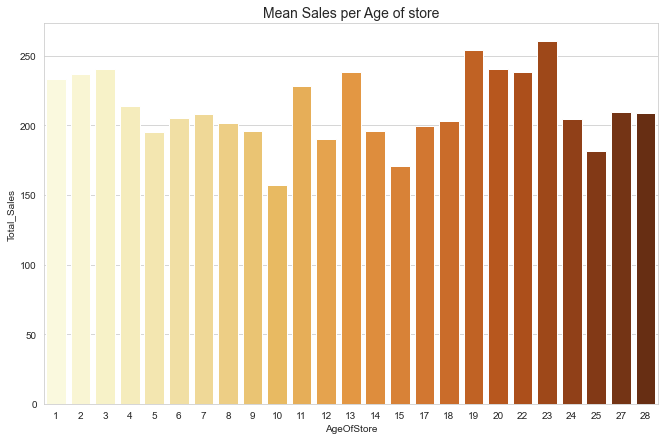

In [25]:
per_age = campaign_total.groupby('AgeOfStore', as_index=False).Total_Sales.mean()
fig, ax = plt.subplots(figsize=(11, 7))
sns.set_style('whitegrid')
pal = sns.color_palette("YlOrBr", len(per_age))
ax = sns.barplot(x='AgeOfStore', y='Total_Sales', data=per_age,  palette=pal)
plt.title('Mean Sales per Age of store', size=14)
plt.show();

<b> The AgeofStore does not seem to be correlated to their sales</b>

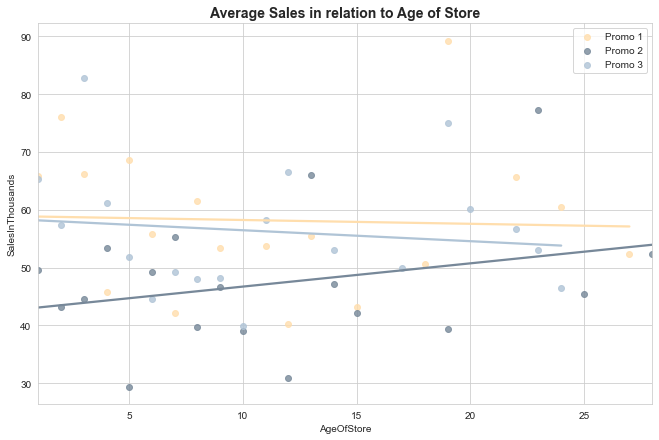

In [26]:
by_age = campaign.groupby(['AgeOfStore', 'Promotion'], as_index=False).SalesInThousands.mean()
by_age_1 = by_age[by_age['Promotion'] == 1]
by_age_2 = by_age[by_age['Promotion'] == 2]
by_age_3 = by_age[by_age['Promotion'] == 3]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))
ax = sns.regplot(x='AgeOfStore', y='SalesInThousands', data=by_age_1, color='navajowhite', ci=None, label='Promo 1')
ax = sns.regplot(x='AgeOfStore', y='SalesInThousands', data=by_age_2, color='lightslategrey', ci=None, label='Promo 2')
ax = sns.regplot(x='AgeOfStore', y='SalesInThousands', data=by_age_3, color='#b0c4d6', ci=None, label='Promo 3')
plt.legend()
plt.title('Average Sales in relation to Age of Store', size=14, weight='bold')
plt.show()

<b>How did each Promotion perform Market-wise?</b>

In [33]:
promotions_by_market = campaign_total.groupby(['MarketID', 'Promotion'], as_index=False).Total_Sales.sum()
promotions_by_market = promotions_by_market.pivot_table(index='MarketID', columns='Promotion')
promotions_by_market.reset_index(drop=True,inplace=True)

In [28]:
#prom1 
prom1 = promotions_by_market['Total_Sales'][1][:].to_numpy()
prom2 = promotions_by_market['Total_Sales'][2][:].to_numpy()
prom3 = promotions_by_market['Total_Sales'][3][:].to_numpy()

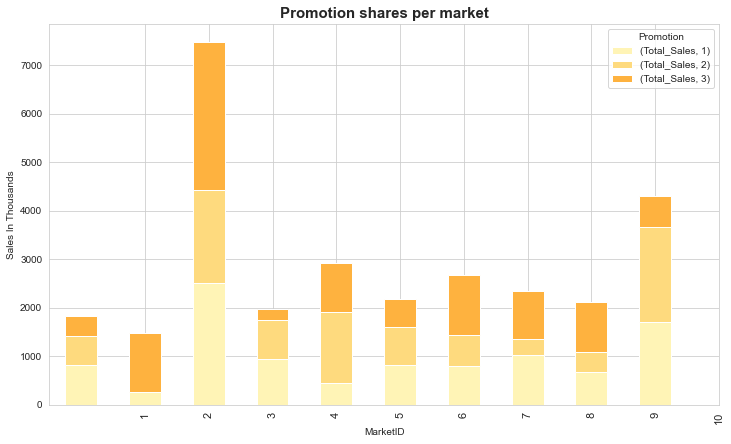

In [32]:
# Distribution of the different promotions among markets )
x = np.arange(1,11)
sns.set_style('whitegrid')
sns.set_palette("YlOrBr")
ax = promotions_by_market.plot(kind='bar', stacked=True, figsize=(12,7))
plt.xticks(ticks=np.arange(1,11), labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
           size=11)
plt.xlabel('MarketID')
plt.ylabel('Sales In Thousands')
plt.title('Promotion shares per market', size=15, weight='bold')
plt.legend(title='Promotion');

In [30]:
shares_by_market = campaign_total.groupby(['MarketID', 'Promotion'], as_index=False).Total_Sales.size()
shares_by_market = shares_by_market.pivot_table(index='MarketID', columns='Promotion')
shares_by_market.reset_index(drop=True,inplace=True)

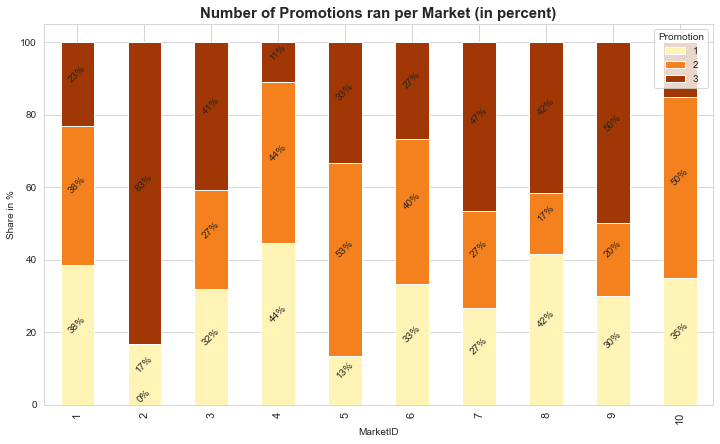

In [41]:

from matplotlib.colors import ListedColormap
ax1= shares_by_market['size'].apply(lambda r: r/r.sum()*100, axis=1)
ax = ax1.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("YlOrBr")), 
          figsize=(12,7))
plt.xticks(ticks=np.arange(0,10), labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
           size=11)
plt.xlabel('MarketID')
plt.ylabel('Share in %')
plt.title('Number of Promotions ran per Market (in percent)', size=15, weight='bold')
for rec in ax.patches:
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom', rotation=45)


In [42]:
sales_per_mark_prom = campaign_total.groupby(['MarketID', 'Promotion']).Total_Sales.mean()
sales_per_mark_prom = sales_per_mark_prom.to_frame(name = 'size').reset_index()
sales_per_mark_prom = sales_per_mark_prom.pivot_table(index='MarketID', columns='Promotion')
ax_test = sales_per_mark_prom.reset_index(drop=True)

<Figure size 432x288 with 0 Axes>

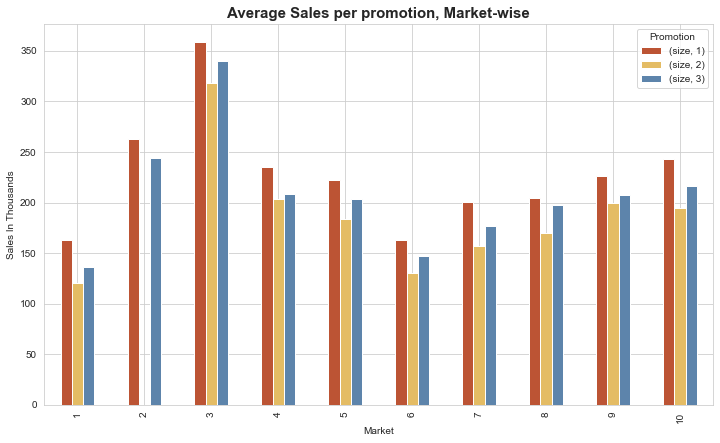

In [43]:
# Distribution of the different promotions among markets 
#fig, ax = plt.subplots(figsize=(12, 7))
#x = np.arange(1,11)
plt.clf()
sns.set_style('whitegrid')
clrs = ['#bc5434' if (x == 1) else '#e4bc64' if (x == 2) else '#5d84ab' for x in ax_test.columns]
ax = ax_test.plot(kind='bar', 
          figsize=(12,7), color=('#bc5434', '#e4bc64', '#5d84ab'))
plt.xticks(ticks=np.arange(0,10), labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylabel('Sales In Thousands')
plt.xlabel('Market')
plt.legend(title='Promotion', loc='upper right', fancybox=True)
plt.title('Average Sales per promotion, Market-wise', size=15, weight='bold')
#plt.savefig('temppp.png', transparent=True, dpi=200)
plt.show();

# Hypothesis Testing

After my exploratory data analysis, I have come to the following conclusions..
1. Each Promotion has ben run on all markets (except MarketID 2, where Promotion 2 is missing)
2. Some markets have more store(LocationID's) than others.
3. ..Which means that comparing the total sales for the markets will not be fair.

<b> My first Hypothesis</b>
<br>
<br>
Null Hypothesis: <i>There is no significant difference between the three promotions and their sales. They all come from the same mean.</i>
<br>
Alternative Hypothesis: <i>There is a significant difference between the three datasets.</i>
<br><br>
If the p-value is < 0.05 I will reject the null hypothesis

In [44]:
promotion_1 = campaign_total['Total_Sales'][campaign_total['Promotion'] == 1].to_numpy()
promotion_2 = campaign_total['Total_Sales'][campaign_total['Promotion'] == 2].to_numpy()
promotion_3 = campaign_total['Total_Sales'][campaign_total['Promotion'] == 3].to_numpy()

In [45]:
# Are the standard deviations of the different promotions significantly different from each other?
print(np.std(promotion_1))
print(np.std(promotion_2))
print(np.std(promotion_3))
# No

63.36300707641075
57.368174927588626
64.83452849242268


In [46]:
# Is the ration between the std's within 10%?
ratio = np.std(promotion_1) / np.std(promotion_2)
print(np.round(ratio, 1))
ratio = np.std(promotion_1) / np.std(promotion_3)
print(np.round(ratio, 1))
ratio = np.std(promotion_2) / np.std(promotion_3)
print(np.round(ratio, 1))
ratio = np.std(promotion_3) / np.std(promotion_2)
print(np.round(ratio, 1))
# Yes

1.1
1.0
0.9
1.1


<b> To compare more than 2 numerical datasets, I perform a one-way ANOVA test</b>

In [48]:
# ANOVA
from scipy.stats import f_oneway
fstat, pval = f_oneway(promotion_1, promotion_2, promotion_3)
np.round(pval,3)

0.004

<b>A p-value of 0.004 means there is a significant difference between the datasets. Let's identify which one stands out. I perform a Tukey's Range Test to see this, and set the significance level to 0.05</b>

In [49]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
v = np.concatenate([promotion_1, promotion_2, promotion_3])
labels = ['Prom 1'] * len(promotion_1) + ['Prom 2'] * len(promotion_2) + ['Prom 3'] * len(promotion_3)

tukey_results = pairwise_tukeyhsd(v, labels, 0.05)
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
Prom 1 Prom 2 -43.0784  0.004  -74.383 -11.7738   True
Prom 1 Prom 3 -10.9382 0.6711 -42.2428  20.3664  False
Prom 2 Prom 3  32.1402 0.0371   1.5392  62.7413   True
------------------------------------------------------


So in general, there is a signicifant difference between Promotion 2 and the Promotion 1 & 3. However the difference in sucess between Promotion 1 and Promotion 3 is not significant.
<br>
<b> 
To summarize: Promotion 1 and 3 did better than Promotion 2
</b>

<b> My second Hypothesis</b>
<br> I would like to know if there's a significant differnce between the promotions, market-wise
<br>
<br>
Null Hypothesis: <i>There is no significant difference between the three datasets (promotions) <b>per each market</b>. They all come from the same mean.</i><br>
Alternative Hypothesis: <i>There is a significant difference between the three datasets.</i><br>
<br>
If the p-value is < 0.05 I will reject the null hypothesis

In [50]:
# Creating a df for each MarketID
one = campaign_total[campaign_total['MarketID'] == 1].reset_index(drop=True)
two = campaign_total[campaign_total['MarketID'] == 2].reset_index(drop=True)
three = campaign_total[campaign_total['MarketID'] == 3].reset_index(drop=True)
four = campaign_total[campaign_total['MarketID'] == 4].reset_index(drop=True)
five = campaign_total[campaign_total['MarketID'] == 5].reset_index(drop=True)
six = campaign_total[campaign_total['MarketID'] == 6].reset_index(drop=True)
seven = campaign_total[campaign_total['MarketID'] == 7].reset_index(drop=True)
eight = campaign_total[campaign_total['MarketID'] == 8].reset_index(drop=True)
nine = campaign_total[campaign_total['MarketID'] == 9].reset_index(drop=True)
ten = campaign_total[campaign_total['MarketID'] == 10].reset_index(drop=True)

<b> I run a one-way ANOVA test for each MarketID</b>

In [51]:
from scipy.stats import f_oneway
markets = [one, two, three, four, five, six, seven, eight, nine, ten]
names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
below_05 = []
from scipy.stats import f_oneway
for df, name in zip(markets, names):
    prom_1 = df['Total_Sales'][df['Promotion'] == 1].to_numpy()
    prom_2 = df['Total_Sales'][df['Promotion'] == 2].to_numpy()
    prom_3 = df['Total_Sales'][df['Promotion'] == 3].to_numpy()
    fstat, pval = f_oneway(prom_1, prom_2, prom_3)
    print('Market {} has a p-value of {}'.format(name,np.round(pval, 4)))
    if pval < 0.05:
        below_05.append(name)
    

Market one has a p-value of 0.0001
Market two has a p-value of nan
Market three has a p-value of 0.0
Market four has a p-value of 0.0019
Market five has a p-value of 0.0004
Market six has a p-value of 0.012
Market seven has a p-value of 0.0002
Market eight has a p-value of 0.0001
Market nine has a p-value of 0.1777
Market ten has a p-value of 0.0


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3339: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


In [52]:
print('There is a significant differenc between the promotions for MarketID: {}'.format(below_05))

There is a significant differenc between the promotions for MarketID: ['one', 'three', 'four', 'five', 'six', 'seven', 'eight', 'ten']


<b> I will now do a Tukey's Range Test for the MarketID's where my ANOVA test showed a significant difference</b>

In [58]:
markets = [one, three, four, five, six, seven, eight, ten]
names = ['one', 'three', 'four', 'five', 'six', 'seven', 'eight', 'ten']

for df, name in zip(markets, names):
    prom_1 = df['Total_Sales'][df['Promotion'] == 1].to_numpy()
    prom_2 = df['Total_Sales'][df['Promotion'] == 2].to_numpy()
    prom_3 = df['Total_Sales'][df['Promotion'] == 3].to_numpy()
    v_set = np.concatenate([prom_1, prom_2, prom_3])
    labels = ['Prom 1'] * len(prom_1) + ['Prom 2'] * len(prom_2) + ['Prom 3'] * len(prom_3)
    tukey_results = pairwise_tukeyhsd(v_set, labels, 0.05)
    per_campaign_market = df.groupby('Promotion', as_index=False).Total_Sales.mean()
    print(name)
    print(per_campaign_market)
    print(tukey_results)

one
   Promotion  Total_Sales
0          1   162.876000
1          2   120.608000
2          3   135.956667
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
Prom 1 Prom 2  -42.268  0.001 -58.1904 -26.3456   True
Prom 1 Prom 3 -26.9193 0.0063  -45.305  -8.5337   True
Prom 2 Prom 3  15.3487 0.1039   -3.037  33.7343  False
------------------------------------------------------
three
   Promotion  Total_Sales
0          1   358.588571
1          2   318.368333
2          3   339.686667
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
Prom 1 Prom 2 -40.2202  0.001 -55.3525 -25.088   True
Prom 1 Prom 3 -18.9019 0.0064  -32.609 -5.1948   True
Prom 2 Prom 3  21.3183 0.0035   6.9831 35.6536   True
-----------------------------------------------------
four
   Promotion  

<b> To determine if there's a clear winner out of the three promotions for <i><u>each market</u></i>, I look at the two promotions with the highest mean sales, and then the result of the Tukey's test to see if the difference is significant. </b> 

In [59]:
clear_winners = [1, 3, 4, 7, 10]

# Summary



In general, Promotion 1 and 3 went better than Promotion 2. For half of the markets, Promotion 1 went significantly better